# Importing Libraries 

In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


Tensorflow version: 2.15.0


# Explorating Dataset

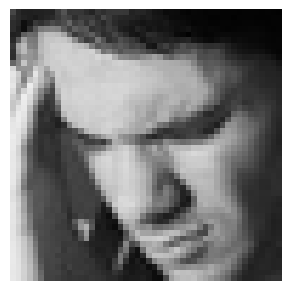

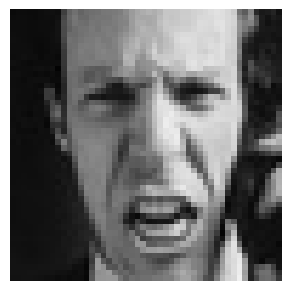

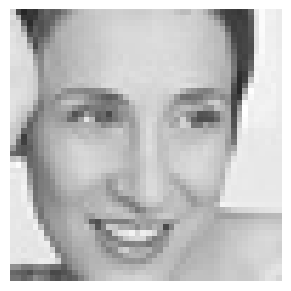

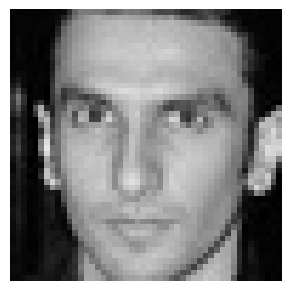

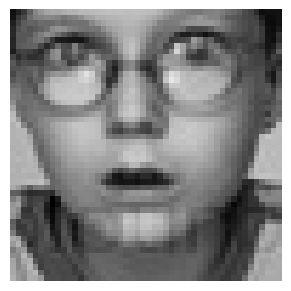

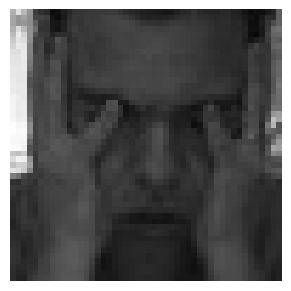

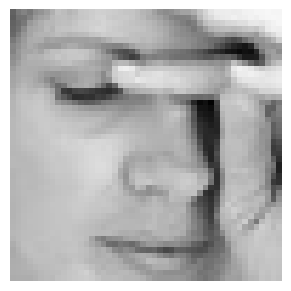

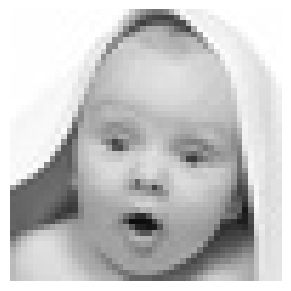

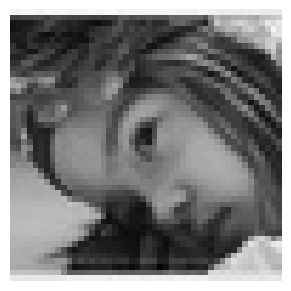

In [4]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

# Preprocessing Data for Training

In [5]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Defining Model

In [7]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [8]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [9]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)

    output  = Dense(7, activation="softmax")(dense_1)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = 'adam' , metrics =["accuracy"])

    return model

In [12]:
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

In [13]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

# Training the Model

In [14]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15


448/448 [==============================] - ETA: 0s - loss: 1.6805 - accuracy: 0.3556
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 125s 265ms/step - loss: 1.6805 - accuracy: 0.3556 - val_loss: 1.4639 - val_accuracy: 0.4319
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3998 - accuracy: 0.4615
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 106s 235ms/step - loss: 1.3998 - accuracy: 0.4615 - val_loss: 1.3319 - val_accuracy: 0.4888
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2760 - accuracy: 0.5117
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 106s 236ms/step - loss: 1.2760 - accuracy: 0.5117 - val_loss: 1.4643 - val_accuracy: 0.4614
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2077 - accuracy: 0.5405
Epoch 4: saving model to model_weights.h5
448/448 [==============================] 

Model Evaluation

In [15]:
model.evaluate(validation_generator)

113/113 [==============================] - 9s 81ms/step - loss: 1.2372 - accuracy: 0.5591


[1.2372394800186157, 0.5590693950653076]

Plotting Loss

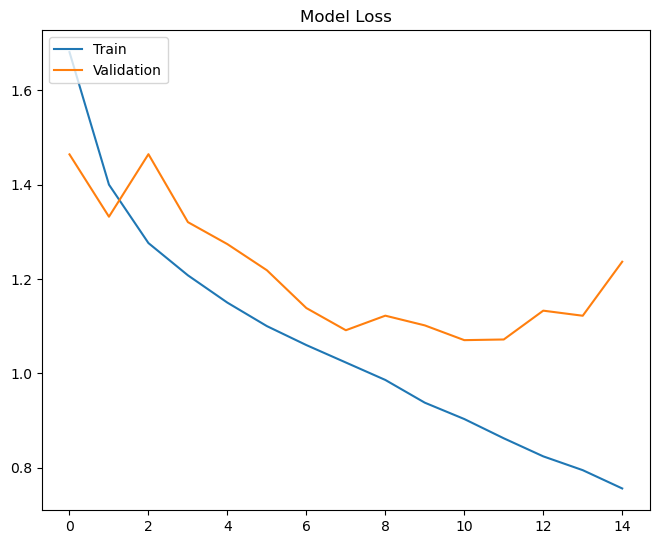

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

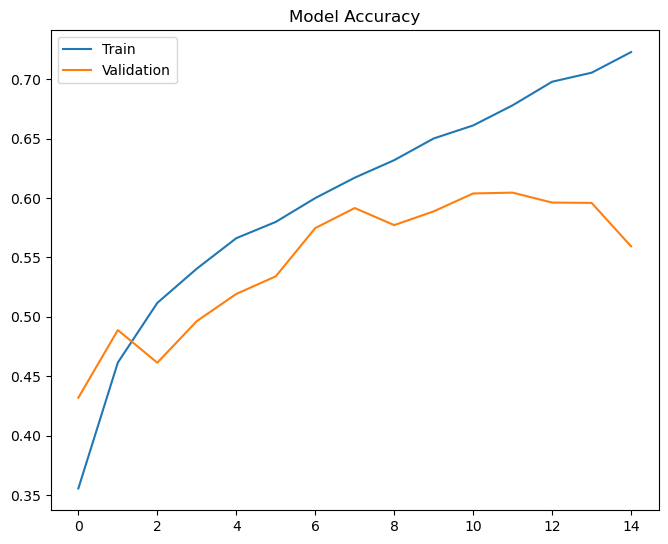

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

Saving Model

In [18]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)